# Lab Session - Basic ML Concepts: Probability Distributions and Information Theory
---

In this lab session, we are going to consider various probability distributions, conditional probability and information theory.

__Note__: You can complete the lab entering code only in the  __# EXPECTED SPACE FOR STUDENT CODE__-blocks as well as the empty cells.

In [1]:
# Imports
# Can be installed through "pip install numpy scipy pandas matplotlib ipympl" or "pip install -r requirements.txt"
import time
from functools import partial
import numpy as np
from scipy.stats import norm #, beta as beta_dist, gamma as gamma_dist, poisson as poisson_dist, nbinom as nbinom_dist
from scipy.linalg import det, inv, pinv
from scipy.optimize import minimize
import pandas as pd # please make sure you have pandas installed (pip install pandas)
import math
import matplotlib.pyplot as plt  # please make sure you have matplotlib installed (pip install matplotlib)
from utils import plot_gaussian, show_images, show_marginals
from typing import List, Optional, Union, Tuple
from collections import Counter



# Exercise 1: Gaussian Distributions

We will start by considering the most prevalent distribution - the Gaussian. The Gaussian has several appealing properties that makes it easy to work with. In the following tasks, we will highlight some of these.

**Note:** For the following tasks, the purpose is to understand the properties of Gaussian distributions. As such, any readly-made distributions (scipy.stats.norm etc.) are disallowed. Using NumPy or SciPy for Linear Algebra is permitted.

Below, you see an implementation of a Gaussian distribution. We will use this highlight and implement properties that are typical of the Gaussian distribution. Please read through, and note the dunder (double under, \_\_methodname_\__) methods that are implemented. These allow us to add and subtract one Gaussian with another.

In [2]:
class GaussianDistribution:
    
    def __init__(self, mean, cov):
        """
        A Gaussian Distribution in arbitrary number of dimensions

        Args:
            mean (np.ndarray): Mean of the distribution.
            cov (np.ndarray): Covariance of the distribution.
        """
        self.mean = np.array(mean).reshape(1, -1)
        self.cov = np.array(cov)
        self.dims = self.mean.shape[1]
        
    def __str__(self):
        """
        Generates a string representation of the object, used for plotting
        and printing

        Returns:
            str: String representation of the object
        """        
        if self.dims == 2:
            string = f'Gaussian, Dim: {self.dims}    Mean: {self.mean}    Covariance: {self.cov[0, :]}{self.cov[1, :]}'
            
        else:
            string = f'Gaussian, Dim: {self.dims}    Mean: {np.round(self.mean[0, 0], 6)}    Covariance: {self.cov}'
        return string.replace('][', '     ').replace('[', '  ').replace(']', '  ')
        
    
    def __add__(self, other):
        """
        Adds two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean + other
            cov = self.cov
        
        else:
            mean = self.mean + other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)
              
    def __sub__(self, other):
        """
        Subtracts two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean - other
            cov = self.cov
            
        else:
            mean = self.mean - other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)  
           
    # sampling is a bit intricate - thus, we cheat a little bit here
    def sample(self, n_samples=1):
        """
        Samples from the distribution.

        Args:
            n_samples (int, optional): The number of samples to generate.
            Defaults to 1.

        Returns:
            np.ndarray: A numpy array of the sampled points.
        """        
        return norm(self.mean, self.cov).rvs(n_samples)
            
    # probability density function - general form
    def pdf(self, points):
        '''
        Evaluates the probability density function of the distribution.

        Args:
            points (np.ndarray): the points we want the probability density of,
            can come in either a list, np.array([dims]) or np.array([samples, dims])
            format
        
        Returns: 
            np.ndarray: A numpy array of probability densities
        '''

        points = np.array(points)
        if len(points.shape) == 1:
            points = points.reshape(1, -1)
            
        offset = points - self.mean
        if self.dims == 1:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(self.cov))
            exponent = np.exp(-0.5 * np.power(offset, 2) / self.cov)
            return norm_const * exponent
            
        else:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(det(self.cov)))
            exponent = np.exp(-0.5 * offset.dot((inv(self.cov)).dot(offset.T)))
            return np.diag(exponent * norm_const)
    
    
    def get_conditional(self, dim, value):
        '''
        Computes the conditional distribution on the remaining dimensions given
        the conditioned value in dimension dim.

        Args:
            dim: int - the dimension (assume only one) which we condition on
            value: float - the value of the conditioned dimension
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        
        # some hints to help:
        
        non_cond_dims = np.arange(self.dims) != dim
        cond_dims = np.arange(self.dims) == dim

        cov_xy = self.cov[non_cond_dims, cond_dims][np.newaxis, :]
        
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(conditional_mean, conditional_cov)

    def marginalize(self, dim):
        '''
        Computes the marginal distribution on the remaining dimensions when having
        marginalized out dimension dim.
        
        Args:
            dim: int - the dimension (assume only one) which we marginalize
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(marginal_mean, marginal_cov)


### Exercise 1.1
We first want to demonstrate how a Gaussian looks and how it is expected to behave - particularly its linear properties. __Throughout this task, we assume that the random variables we work with are independent of one another__ (e.g. __A__ is independent of __B__). Create four Gaussians:

__A__: $\mu = 1, \sigma^2 = 2$

__B__: $\mu = -2, \sigma^2 = 0.1$

__C__: $\mu = \begin{bmatrix}
1 & 0
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & 0.9\\
0.9 & 2
\end{bmatrix}$

__D__: $\mu = \begin{bmatrix}
-1 & 2
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & -0.7\\
-0.7 & 1
\end{bmatrix}$

Visualize, through the provided plotting function below, _plot_gaussian_:

a. __A__

b. __B__

c. __A__ + __B__

d. __C__

e. __D__

f. __C__ - __D__

__Questions__:

1. What is meant by "The Gaussian distribution is fully characterized by its mean and covariance"?
2. If two Gaussians are added, can the (co-)variance ever decrease?

__Answers__:

1.
2.

In [3]:
# EXPECTED SPACE FOR STUDENT CODE - START
# gaussian_A = GaussianDistribution(mean=np.array([1]), cov=np.array([2]))

# plot_gaussian(gaussian_A)
# EXPECTED SPACE FOR STUDENT CODE - END

### Exercise 1.2
__Task__: Implement the `marginalize` function of the class GaussianDistribution. Test, for __C__, that your resulting Gaussian looks like the one in the plot. Plot the resulting distribution for __C__ when marginalizing on $y$, and on __D__ when marginalizing on $x$.

__Question__: What does one effectively do when marginalizing a variable of a distribution?

__Answer__:


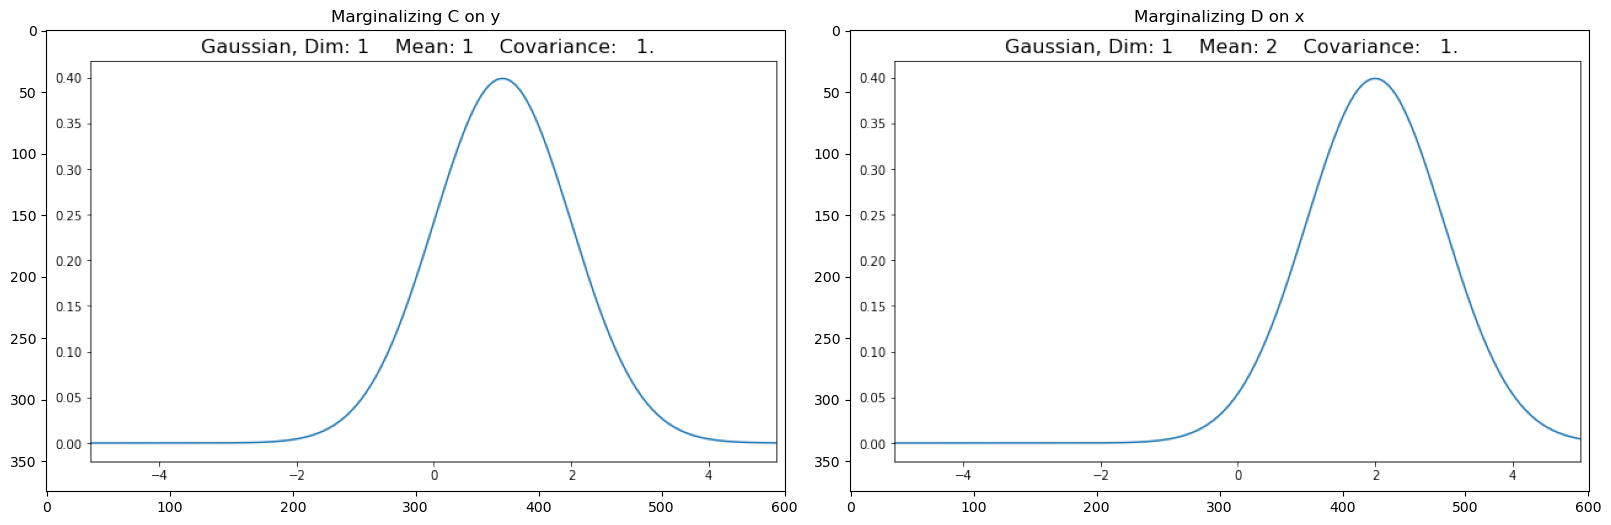

In [4]:
show_marginals()

In [5]:
# Some code to test if you've marginalized distribution C correctly
# marg_C = gaussian_C.marginalize(dim=1)

# plot_gaussian(marg_C)

### Exercise 1.3
__Task__: Implement the `get_conditional` function of the class GaussianDistribution. Test, for the Gaussians __C__ and __D__ from 1.1, that your resulting conditional looks like the ones in the plots, when conditioning on $x=2$ and $y=4$, respectively. 

__Hint 1__: Use the numpy arrays to retrieve the right dimensions when performing the computation (`cond_dims` are the dimensions we condition on, `non_cond_dims` are the non-conditioned dimensions). Example:

$\Sigma_{yx} = $ `self.cov[cond_dims, non_cond_dims][:, np.newaxis]`

__Hint 2__: Use either np.matmul, np.dot or the @ operator to perform matrix matrix multiplications.

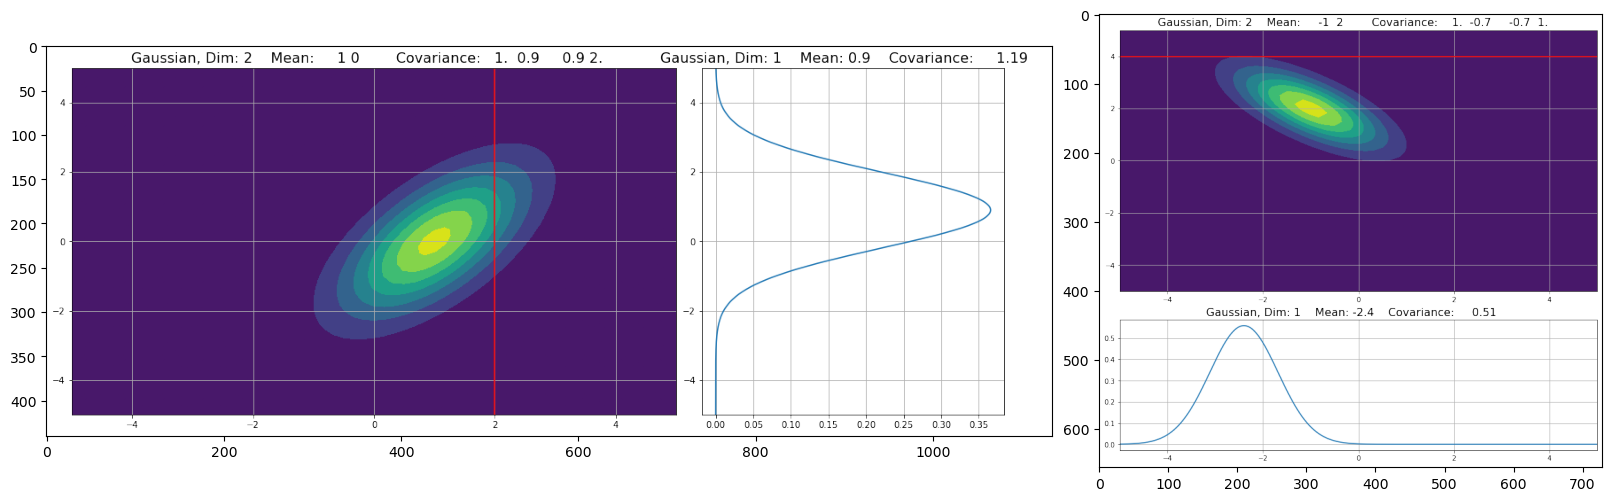

In [6]:
show_images()

In [7]:
# Test that this produces the same plot (including the colors, which indicates the computed pdf)
# gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))

# Use these lines to compute the conditionals
# conditional_C = gaussian_C.get_conditional(dim=0, value=2)

# Use these lines to generate the plots - plots both the initial distribution and the conditional along the right axis
# plot_gaussian(gaussian_C, conditional_dist=conditional_C, condition_axis=0, condition_value=2)

# Exercise 2: Information Theory

Here, we will work with entropy, information gain and mutual information.

### Exercise 2.1
In this exercise we are going to work with characters in an alphabet.
Assume, you have a string 'cdd', then the frequencies of 'c' and 'd' are $ p(^\prime{}c^\prime{})=\frac{1}{3} $ and $ p(^\prime{}d^\prime{})=\frac{2}{3} $.
We can interpret $ p $ as a probability distribution over an alphabet.

Assume you only have two characters in an alphabet, 'a' and 'b'. 


* **What does the probability of 'a' and 'b' have to be in order for the entropy to be maximal?**
* **What is the maximum value of the entropy in this case?**
* **Intuitively, why is the entropy maximum for the value you found?** (You can calculate it on paper or write it in Python, you will need it later anyway)

***Your answers:***

### Exercise 2.2

Still assume that your alphabet consists of only two characters, 'a' and 'b'.
For values $ p(^\prime{}a^\prime{}) = 0.01, 0.02, \ldots, 0.99 $, plot the entropy of your alphabet ($ x $-axis: $ p(^\prime{}a^\prime{}) $, $ y $-axis: Entropy in bits).
Your plot should contain only one line.

If you don't know how to plot with Matplotlib, there is a really short crash course in the next cell.

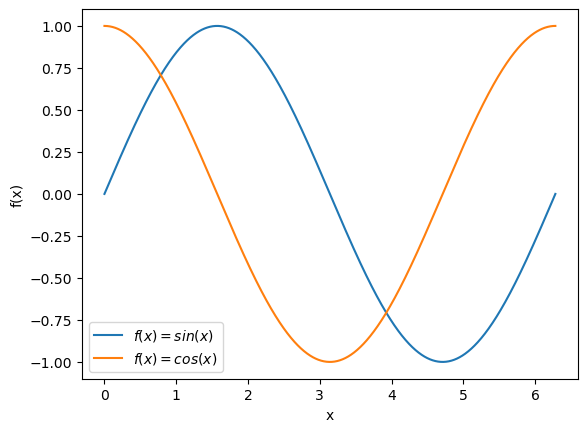

In [8]:
x = np.linspace(0, 2 * math.pi, 1000)  # generate 1000 x-values between 0 (inclusive) and 2 pi (inclusive)
y1 = np.sin(x)  # compute sine of x elementwise
y2 = np.cos(x)  # compute sine of x elementwise
plt.plot(x, y1, label=r"$f(x)=sin(x)$")  # plot values with label
plt.plot(x, y2, label=r"$f(x)=cos(x)$")  # plot values with label
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()  # show legend
# you might need to run plt.show() if nothing shows up

In [9]:
# ******************
# * Your code here *
# ******************

### Exercise 2.3
A measure that is related to Entropy is the *Gini Impurity* which is defined as
$$
    G(p) = 1-\sum_{x\in\mathcal{X}}p(x)^2
$$

Both entropy and Gini impurity are used in decision tree learning to measure the ``level of disorderliness''. In the following, we want to discover similarities and differences.

Extend the plot from Exercise 2.2, such that you also plot the Gini Impurity for the different values of $ p(^\prime{} a^\prime{}) $. **What do you notice?**

In [10]:
# ******************
# * Your code here *
# ******************

Now we extend our comparison to three dimensions. We have three variables $ x_1 $, $ x_2 $, and $ x_3 $ and plot their entropies and Gini impurities.
The $ x $- and $ y $-axes show the values $ p(x_1) $ and $ p(x_2) $, respectively. The value $ p(x_3) $ is implicitly defined as $ 1-p(x_2)-p(x_1) $.
We also plot the point of maximum entropy / gini impurity. 

**What do you notice? If you have $ n $ instead of three random variables, what are the bounds for the entropy and the Gini impurity?**

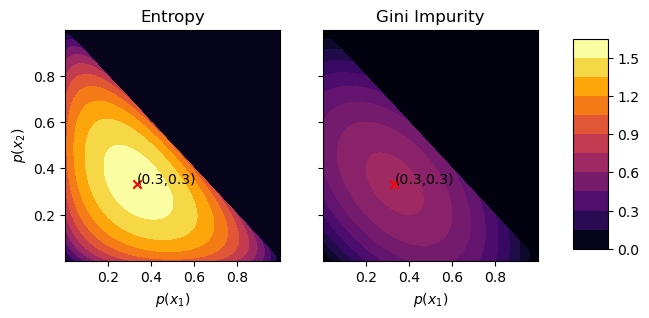

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
resolution = 501
x = np.linspace(1e-8, 1 - 1e-8, resolution)
y = np.linspace(1e-8, 1 - 1e-8, resolution)
xx, yy = np.meshgrid(x, y)


def entropy(x, y):
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    z = 1 - x - y
    res = x * np.log2(x) + y * np.log2(y) + z * np.log2(z)
    res[np.isnan(res)] = 0
    # we didn't ensure that z isn't negative above, so we manually set nan values to 0 here
    
    return -res


def gini_impurity(x, y):
    z = 1 - x - y
    gin = 1 - x ** 2 - y ** 2 - z ** 2
    # we work with probabilities so we only consider the cases where x+y+z = 1 *AND* x >=0, y>=0, z>=0
    # but you can actually see something interesting if you remove this (other than for the entropy)
    gin[z < 0] = 0
    return gin


ims = []
for _ax, measure, label in zip(ax, [entropy, gini_impurity], ['Entropy', 'Gini Impurity']):
    values = measure(xx, yy)
    im = _ax.contourf(xx, yy, values, levels=10, vmin=0, vmax=np.log2(3), cmap='inferno')
    ims.append(im)
    max_idx = np.unravel_index(np.argmax(values, axis=None), values.shape)
    _ax.text(max_idx[0] / resolution,
             max_idx[1] / resolution,
             f"({max_idx[0] / resolution:.1f},{max_idx[1] / resolution:.1f})")
    _ax.scatter(max_idx[0] / resolution, max_idx[1] / resolution, marker='x', color='r')
    _ax.set_title(label)
    _ax.set_xlabel(f'$p(x_1)$')
ax[0].set_ylabel(r'$p(x_2)$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ims[0], cax=cbar_ax)

# Exercise 3

In the next exercise, we will work with joint probability distributions. For this purpose, we use the Kaggle Titanic dataset which consists of records of survivors and non-survivors of the Titanic disaster. For this exercise, we will be only interested in some of the attributes, `Survived` and `Sex`.

In [ ]:
titanic = pd.read_csv("titanic.csv")
titanic

For example, we can find the male passengers as follows

In [ ]:
titanic.query("Sex == 'male'")

and we can find the number male passengers by

In [ ]:
len(titanic.query("Sex == 'male'"))

Similarly, we can filter by multiple attributes, for example, to find all male passenger in the third class

In [ ]:
titanic.query("Sex == 'male' and Pclass == 3")

We can select only the passenger names by

In [ ]:
titanic['Name']

### Exercise 3.1

***Fill in the following table.*** 

The random variable $ S $ describes a passenger's sex, the variable $ V $ whether they survived or not.


| $ S $ / $ V $ | dead | alive | P($ S $) |
| --------- | ---- | ----- | ------ |
| **female** | ??? | ??? | ??? |
| **male** | ??? | ??? | ??? |
| **P($ V $)** | ??? | ??? | 1 |

### Exercise 3.2

* **Find the value $ H(S) $. Is this a high or a low entropy? For what distribution would the uncertainty be maximal/minimal (with which value)?**

In [ ]:
# *****************
# *** Your code ***
# *****************

### Exercise 3.3

It is commonly said that the class you traveled in affected your survival chances. Let's test this.

* **Calculate $ H(V) $, $ H(V|C) $, and $ MI(V; C) $** where $ C $ is an RV for the class ('Pclass' in the dataset). Does knowing the class you traveled in reduce your uncertainty about whether a passenger died?

In [ ]:
# *****************
# *** Your code ***
# *****************

### Exercise 3.4

Now do the same for $ H(V|S) $ and $ MI(V; S) $.

* **Which does help you more in deciding whether a passenger died or not, knowing their sex or travel class?**

In [ ]:
# *****************
# *** Your code ***
# *****************

# Exercise 4 - MLE, Overfitting and Cross-validation
Here, we are going to look at a synthetic regression problem, and how under- and overfitting can occur through better or worse model parameterizations. We will also look at the most common mean of evaluating model performance, namely cross-validation. We'll consider learning the function below through polynomial regression on a number of given data points:

In [ ]:
def true_function(X):
    return 12 * np.exp(-1e6 * np.power(1.2 * (X - 0.5), 16)) * np.sin((X - 0.5))

def noisy_function(X):
    return true_function(X) + np.random.randn(X.size) * 0.04

eval_points = np.array([0.01, 0.1, 0.21, 0.52, 0.61, 0.78, 0.80, 0.81, 0.99])
X_plot = np.linspace(0, 1, 101)

fig3, ax3 = plt.subplots()
ax3.plot(X_plot, true_function(X_plot), label='True function')
ax3.scatter(eval_points, noisy_function(eval_points), c='r', label='Training points')
ax3.legend()
ax3.set_ylim(-5, 5)
plt.show()

### Exercise 4.1
Look at the class `PolynomialRegression` (a type of Generalized Linear Model) and pay attention to its attributes and _predict_ method. This class is intended to fit a polynomial of a given degree to the data points, by calling some method to fit the data points.

__Task__: Implement the closed-form Maximum Likelihood parameter estimation in the `fit_MLE` method. The closed-form expression for the optimal parameters can be found in the Lecture 3 on the section on Maximum Likelihood. Ensure it works by fitting a polynomial of degree 10 to the data points - it should fit most data points reasonably well.

__Hint__: Keep in mind that a polynomial of degree 2 has 3 coefficients.

In [ ]:
class PolynomialRegression:
    
    def __init__(self, degree):
        """
        A Polynomial Regression model of a given degree,

        Args:
            degree (int): The degree of the polynomial regression.
        """        
        self.degree = degree
        self.weights = None
        
    def fit_MLE(self, X, y):
        """
        Fits the weights of the model according to the Maximum Likelihood.

        Args:
            X ([type]): The explanatory variables of the data.
            y ([type]): The dependent variables of the data.
        """
        # EXPECTED SPACE FOR STUDENT CODE - START

        # here, you fit the weights closed-form according to MLE

        # EXPECTED SPACE FOR STUDENT CODE - END
    
    
    def predict(self, X):
        """
        Predicts the output value(s) of a fitted model on the data point(s) X,

        Args:
            X ([type]): The explanatory variables of the data point(s) that is to 
            be predicted..

        Raises:
            ValueError: If no model is fitted (self.weights are None), no prediction
            can be made and an error is raised.

        Returns:
            np.ndarray: The predicted output value of the data point(s) X.
        """        

        if self.weights is None:
            raise ValueError('Need to fit the model before predicting!')

        theta = np.power(X[:, np.newaxis], np.arange(self.degree+1))
        preds = theta.dot(self.weights)
        return preds
            
    def print_weights(self):
        """
        Prints the weights of the model in a structured format.
        """        
        for i in range(self.degree):
            print('Coeff. theta^{}:   {:.2f}'.format(i, self.weights[i]))

In [ ]:
polynomial_degree = 3

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_1, ax3_1 = plt.subplots()
ax3_1.plot(X_plot, true_function(X_plot), label='True function')

ax3_1.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_1.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_1.set_ylim(-5, 5)
ax3_1.legend()
plt.show()

### Exercise 4.2
We will now discover what happens if we under- and overfit parameters, as well as how additional data helps counteract overfitting. 

__Task__: Toy around with the fit of the generalized linear model below to find degrees where it under- and overfits. Try polynomials of different orders by changing the _polynomial_degree_ parameter. When you overfit, try change the _added_samples_ parameter.


__Questions__:

1. Judging by eye, which degree seems to consistently give the best fit?
2. How can one tell, only by looking at the parameter values of the model, if overfitting has occured?

__Answer__:

1.
2.

In [ ]:
# Test out these parameters to answer the questions!
polynomial_degree = 12
added_samples = 30

pr = PolynomialRegression(polynomial_degree)
X_added = np.random.uniform(size=added_samples)
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
y_added = noisy_function(X_added)

all_X = np.append(X_eval, X_added, axis=0)
all_y = np.append(y_eval, y_added, axis=0)

pr.fit_MLE(all_X, all_y)
pr.print_weights()

In [ ]:
X_plot = np.linspace(0, 1, 101)
fig3_2, ax3_2 = plt.subplots()

ax3_2.plot(X_plot, true_function(X_plot), label='True function')

ax3_2.scatter(X_eval, y_eval, c='r', label='Training points')
if added_samples > 0:
    ax3_2.scatter(X_added, y_added, c='g', label='Additional points')
ax3_2.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_2.set_ylim(-5, 5)
ax3_2.legend()
plt.show()

### Exercise 4.3
To evaluate the models produced, one commonly uses cross-validation. 

__Task__: Implement K-fold cross validation and find your best model with RMSE as your metric. Plot the best model. Use only the initial data, without additional samples. Implement yourself or use an existing tool, e.g.  <a href="http://scikit-learn.org/stable/modules/cross_validation.html" title="Scikit-Learn Cross Validation">Scikit-Learn</a>.

__Tip__: Ensure nearby points don't go in the same batch, so that every model has data from the entire space.

__Question__:
What performance (RMSE, average on the test sets) did your top-performing model yield for K = 5?

__Answer__:

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START

# EXPECTED SPACE FOR STUDENT CODE - END

### Exercise 4.4 (Optional)

You might have noticed that when you set the polynomial degree higher than the number of data points, the polynomial does not fit the data perfectly. However, this is what you would expect as the linear system of equations is overconstrained (test this by, e.g., using a polynomial of degree 100):

In [ ]:
polynomial_degree = 100

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_3, ax3_3 = plt.subplots()
ax3_3.plot(X_plot, true_function(X_plot), label='True function')

ax3_3.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_3.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_3.set_ylim(-5, 5)
ax3_3.legend()
plt.show()

Below is the closed-form MLE solution which you (probably) used to solve above question. However, note that our original problem is a least squares problem:

$$
   \min_{\mathbf{\beta}} || \mathbf{y} - \theta\beta  ||^{2}
$$

You might have noticed that for high polynomial degrees, the polynomial does not fit the datapoints perfectly - even though this is what you would expect. This is because using the closed-form solution is numerically unstable. In fact, we are better off using NumPy's `numpy.linalg.lstsq` which takes the design matrix $\theta$ and the vector $\mathbf{y}$ as input and returns a $\beta$ that satisfies above formula. `numpy.linalg.lstsq` uses an iterative approach for solving the problem and is much more stable.

**Task:** Change the `fit_MLE` function to use `numpy.linalg.lstsq` and see how the solution gets more stable by using polynomials of high degrees. Note that `numpy.linalg.lstsq` returns a tuple from which you need the first element, also you might want to set `rcond=None` when calling `numpy.linalg.lstsq` to suppress warnings.

After changing the `fit_MLE` function, the polynomial of degree 100 should fit all points perfectly.